![]()

## Lesson: PyMC & Bayesian Regression

> Author: Matt Brems

### LEARNING OBJECTIVES
By the end of the lesson, students should be able to:
- Define conjugacy.
- Fit models in PyMC.
- Interpret traceplots, posterior distributions, and posterior predictions.

---

## Recap
Remember that parameters have distributions. In Bayesian statistics, our goal is to **find the posterior distribution of our parameter of interest**.

<details><summary>In order to generate a posterior distribution, what are the two components we need?</summary>

- Prior distribution summarizing our beliefs about the parameter before observing any data.
- Likelihood function summarizing how our data were generated.
</details>

In [ ]:
# Install pymc3
# !pip install pymc3

In [1]:
# Import the necessary packages:

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import beta, binom
# from scipy.stats import binom

%matplotlib inline

## The Situation
$$ X | p \sim \text{Binomial}(n, p)$$
$$ p \sim \text{Beta}(a, b) $$

This is our code from yesterday, except we've added a legend and labels, and resized the plot.

In [2]:
def plot_beta_binomial(a, b, n_trials, n_successes, n_steps = 100):
    plt.figure(figsize = (12,8))
    
    xs = np.linspace(0, 1, n_steps)
    
    ## Calculating prior, likelihood, and posterior.
    prior = beta(a, b).pdf(xs)
    likelihood = binom(n_trials, xs).pmf(k=n_successes)
    posterior = prior * likelihood
    
    ## Plotting colored lines here to show prior mode, the maximum likelihood value, and posterior mode.
    plt.vlines([(a - 1) / (a + b - 2), n_successes / n_trials, (a + n_successes - 1) / (a + b + n_trials - 2)],
               ymin = 0,
               ymax = max(max(prior),max(likelihood), max(posterior)), # height of dotted lines
               linestyles = 'dashed',
               colors = ['tab:orange', 'tab:green', 'tab:blue'])
    plt.yticks([])
    
    ## Plotting prior, likelihood, and posterior.
    plt.title("Prior, Likelihood, and Posterior Modes", fontsize = 18)
    plt.xlabel("Values of $p$", fontsize = 16)
    plt.plot(xs, prior, c = 'tab:orange', label="Prior")
    plt.plot(xs, likelihood, c = 'tab:green', label="Likelihood")
    plt.plot(xs, posterior, c = 'tab:blue', label='Posterior')
    plt.legend(loc = 2, fontsize=14);

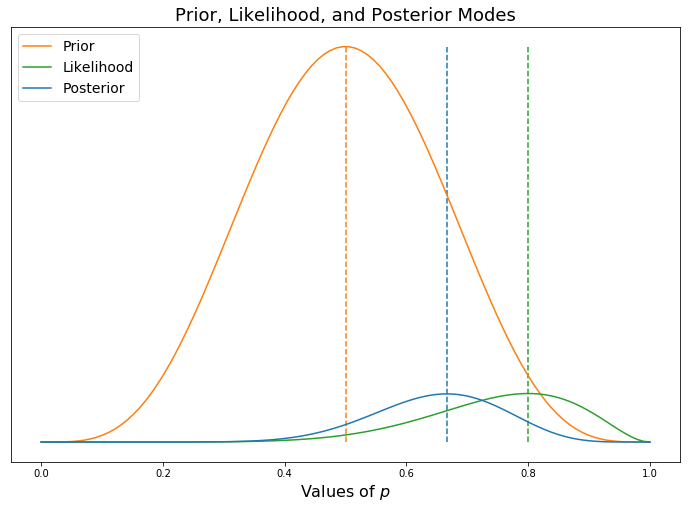

In [3]:
plot_beta_binomial(a = 5,           # Hyperparameter alpha for Beta(alpha, beta)
                   b = 5,           # Hyperparameter beta for Beta(alpha, beta)
                   n_trials = 10,   # Hyperparameter n for Binomial(n, k)
                   n_successes = 8) # Hyperparameter k for Binomial(n, k)

#### Generate a Beta(1.000001, 1.000001) prior with a Binomial(10, 8) likelihood.

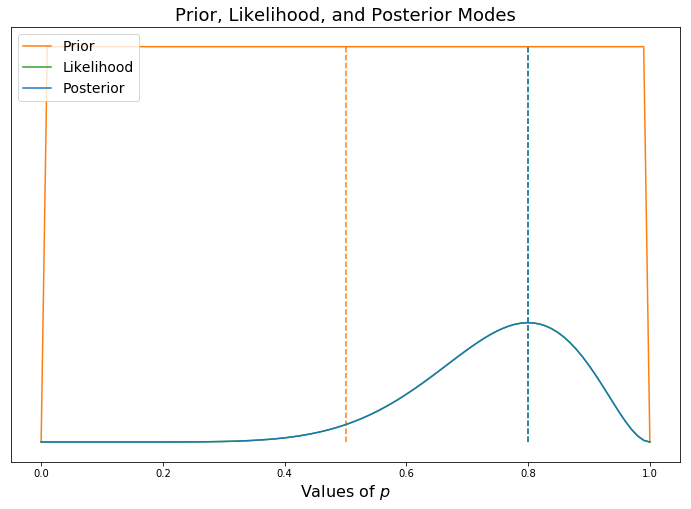

In [4]:
plot_beta_binomial(
    a=1.000001,
    b=1.000001,
    n_trials=10,
    n_successes=8
)

<details><summary>How would you describe this prior, likelihood, and posterior?</summary>

- Our prior is (basically) perfectly flat on the (0,1) interval.
- Our likelihood and posterior are perfectly in sync, both peaking at 80%.
</details>

---
<details><summary>In this case, why does our posterior look the way it does?</summary>

- Since our prior is flat over all possible values of our parameter, our posterior will be entirely determined by the likelihood.
</details>

#### Generate a Beta(500, 500) prior with a Binomial(10, 8) likelihood. 

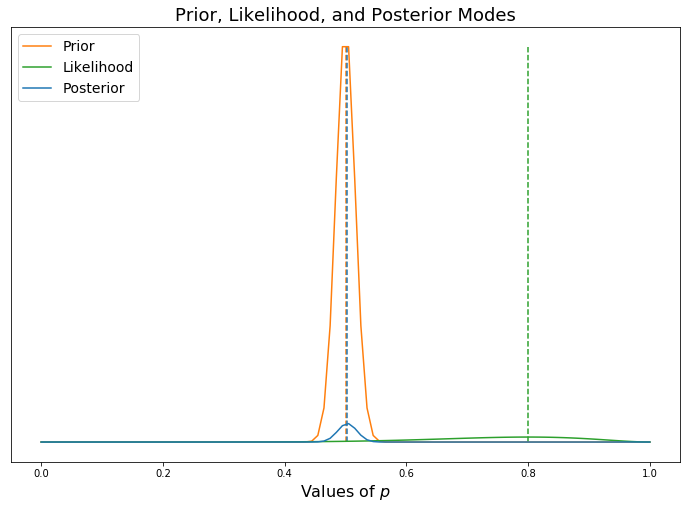

In [5]:
plot_beta_binomial(
    a=500,
    b=500,
    n_trials=10,
    n_successes=8
)

<details><summary>How would you describe this prior, likelihood, and posterior?</summary>

- Our prior has almost all of its weight at exactly 50%.
- Our likelihood is still peaked at 80%, but has a decent amount of spread.
- Our posterior mode syncs up with the prior mode.
</details>

---

<details><summary>In this case, why does our posterior look the way it does?</summary>

- When our prior distribution is very specific, then our posterior distribution will be almost entirely determined by the prior.
</details>

#### Generate a Beta(5, 5) prior with a Binomial(1000, 800) likelihood.

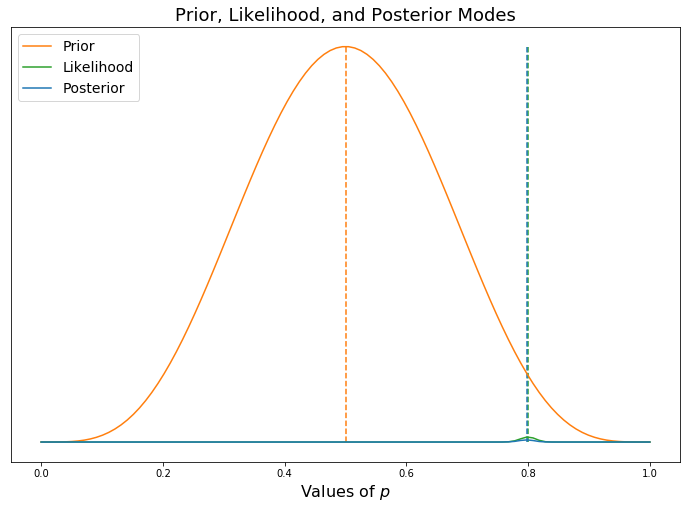

In [6]:
plot_beta_binomial(
    a=5,
    b=5,
    n_trials=1000,
    n_successes=800
)

<details><summary> How would you describe this prior, likelihood, and posterior? </summary>

- Our prior is centered at 50%, but has a decent amount of spread.
- Our likelihood is still peaked at 80%, but has minimal spread. (We've flipped 1000 coins and gotten 800 heads!)
- Our posterior mode syncs up with the mode of our likelihood function.
</details>

---

<details><summary>In this case, why does our posterior look the way it does?</summary>

- When our sample size is large, then our likelihood will exert more influence on the posterior distribution.
</details>

### Conjugacy

We can get a really nice-looking distribution for the posterior in the above cases. In fact, the situation we chose here has a very nice property.

If I have: 
- a $Beta(\alpha,\beta)$ prior, and 
- a $Binomial(n,k)$ likelihood, 
- then my posterior is **exactly** $Beta(\alpha+k-1, \beta+(n-k)-1)$.

This property is known as **conjugacy**.

Explicitly, if our prior and likelihood follow the same parametric form, then the prior and posterior are called **conjugate distributions**.

This can be written:

$$ X | p \sim \text{Binomial}(n, p) $$
$$ p \sim \text{Beta}(\alpha, \beta) $$
$$ \Longrightarrow p | X \sim \text{Beta}(\alpha + k - 1, \beta + n - k - 1) $$

Another example... if I have:
- a Normal prior and 
- a Normal likelihood, 
- then my posterior is **exactly** Normally distributed. (The exact formulation is pretty complex.)

**We are not guaranteed to have conjugacy!** If I pick a Cauchy distribution for my prior and a Gamma distribution for my likelihood, we aren't guaranteed to have a posterior that is Cauchy.

Check more out [here](https://en.wikipedia.org/wiki/Conjugate_prior).

<details><summary>Why might conjugacy have been so important in the past?</summary>
```
- Before computers were so cheap and before software was so efficient, we had to do statistics by hand. Multiplying a prior by a likelihood was hard work, so if we could select a prior and likelihood that "played nicely" together, then we made our lives easier.
- This is no longer necessary!
```
</details>

## Enter MCMC
Markov chain Monte Carlo methods (commonly abbreviated MCMC methods) made conjugacy mostly unnecessary.

![](./images/posterior_samples.png)

[TL;DR](https://en.wikipedia.org/wiki/TL;DR) of MCMC: We use computers to take our prior and likelihood, then simulate a large number of samples from the posterior.
- If I want to find the mean of my posterior distribution, then I can just do `np.mean(xs)`, where `xs` is my saved list of samples from my posterior.
- If I want to find the median of my posterior distribution, then I can do `np.median(xs)`.
- If I want to find the 95% [credible interval](http://www.statisticshowto.com/credible-interval/) for my parameter based on the posterior distribution of my parameter, then I can just find the 2.5th and 97.5th percentiles of `xs`!

*We'll do a full lesson on how MCMC works tomorrow!*

Today, we're going to use `PyMC3`, a Bayesian modeling library in Python that will enable us to use Markov chain Monte Carlo methods. Luckily, this is a package that is geared toward scientists, not necessarily statisticians. We'll be able to use what we currently know about Bayesian statistics to leverage this *really* powerful library.

In [7]:
# Import PyMC3.

import pymc3 as pm

Suppose I want to compare mothers' heights to daughters' heights. I want to fit a simple linear regression model

$$Y | \beta_0, \beta_1, \sigma = \beta_0 + \beta_1X + \varepsilon$$
with
$$\varepsilon \sim Normal(0,\sigma)$$

, where I'll use the mother's height as my $X$ variable to predict the daughter's height as my $Y$.

---

<details><summary>What is/are the unknown parameter(s) we want to estimate?</summary>
    
- $\beta_0$
- $\beta_1$
- $\sigma$
</details>

### Since we're good Bayesians...
- Our goal is to calculate the posterior distribution of the parameter(s) of interest.
- In order to get a posterior distribution, we need to identify a prior and a likelihood.
- **Before looking at our data, we should settle on a prior.**

---

## Prior Distribution

Let's just focus on one at a time. 

Spend a few minutes and brainstorm:
- a prior for $\beta_1$ that is so vague that it's basically just a Frequentist approach.
    * $U(-\infty, \infty)$
    * $U(-10000, 10000)$
    * $N(0, 10000)$
- a prior for $\beta_1$ that is highly informative.
    * $N(1, 1)$
- a prior for $\beta_1$ that is so specific that it's too informative.
    * $N(1, 0.001)$
---

Spend a few minutes and brainstorm:
- a prior for $\beta_0$ that is so vague that it's basically just a Frequentist approach.
- a prior for $\beta_0$ that is highly informative.
- a prior for $\beta_0$ that is so specific that it's too informative.

In [8]:
import pandas as pd

In [9]:
# Read in our data for today.

df = pd.read_csv('datasets/heights.csv', index_col=0)

In [10]:
df.head()

,Mheight,Dheight
1,59.7,55.1
2,58.2,56.5
3,60.6,56.0
4,60.7,56.8
5,61.8,56.0


In [11]:
# Instantiate model.

model = pm.Model()

In [12]:
# Set priors for parameters.

with model:
    beta_0 = pm.Normal('beta_0', mu=0, sd=5)
    beta_1 = pm.Normal('beta_1', mu=1, sd=0.2)
    sigma = pm.Uniform('sigma', lower=0, upper=8)

### Likelihood

When fitting a linear regression model in the past, we've assumed that our data followed a Normal distribution!

- Note that we've written $Y = \beta_0 + \beta_1X + \varepsilon$, where $\varepsilon \sim Normal(0, \sigma)$.
- We can rewrite this as $Y \sim Normal(\beta_0 + \beta_1X, \sigma)$.
    - While this might be annoying, it helps us to better understand that we think our data $Y$ follow a Normal distribution and that we want to estimate $\beta_0$, $\beta_1$, and $\sigma$.

![](./images/normal.png)

In [13]:
# Set likelihood function.
with model:
    Y_obs = pm.Normal(
        'Y_obs',
        mu = beta_0 + beta_1*df['Mheight'],
        sd = sigma,
        observed = df['Dheight']
    )

$$
\begin{eqnarray*}
Y &\sim& N(\beta_0 + \beta_1X, \sigma) \\
\beta_0 &\sim& N(0, 5) \\
\beta_1 &\sim& N(1, 0.2) \\
\sigma &\sim& Uniform(0,8)
\end{eqnarray*}
$$

### Now let's do our inference!

Before getting started, note that we don't just have one posterior distribution.
- We have a posterior distribution of $\beta_0|y$.
- We have a posterior distribution of $\beta_1|y$.
- We have a posterior distribution of $\sigma|y$.

## The Inference Button$^{TM}$

In [14]:
with model:
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]
Sampling 4 chains: 100%|██████████| 44000/44000 [02:40<00:00, 273.67draws/s]


### What is happening here?

- **Conjugacy** (where our prior and posterior follow the same parametric form) is an awesome thing to have, but we don't always have it!
- When I'm working to conduct inference on multiple parameters or have distributions that don't "play nicely" together, I'm not even guaranteed a closed-form solution!
- We may need to rely on our computer to "find" our posterior distribution.
- Realistically, our computer is taking our prior distribution(s), our likelihood function(s), and doing a sophisticated Markov chain Monte Carlo (MCMC) method sampling technique.
- Basically, we "press go" and the algorithm will generate samples from the posterior distribution. (In this case, 10,000 samples from the posterior.)
- Because this algorithm needs to **converge** (more on this tomorrow), we set a number of tuning steps to occur first (in this case, 1,000) and where the algorithm should "start exploring."

## All together, now
We split our model up into multiple cells so we can talk about it bit-by-bit, but in real life, this is usually done all at once. That is, in production, we'd write it like this:

```python
with pm.Model() as model:
    # Set priors for parameters
    beta_0 = pm.Normal('beta_0', mu=0, sd=5)
    beta_1 = pm.Normal('beta_1', mu=1, sd=0.2)
    sigma = pm.Uniform('sigma', lower=0, upper=8)
    Y_obs = pm.Normal(
        'Y_obs',
        mu = beta_0 + beta_1*df['Mheight'],
        sd = sigma,
        observed = df['Dheight']
    )
    trace = pm.sample(10000, tune=1000)
```

There are two main things we can do once our algorithm has finished.
1. Our 10,000 samples should be from the posterior distribution, so we can approximately visualize the posterior distribution.
2. We can find the summaries of our posterior distributions.

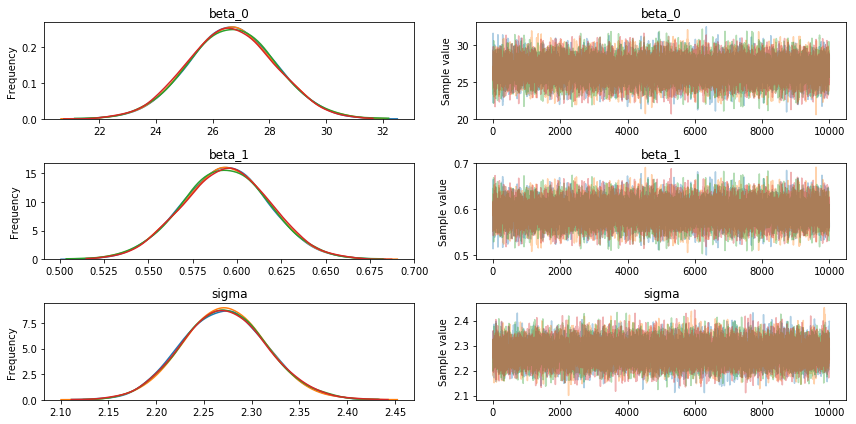

In [15]:
# Generate full posterior distributions.
pm.traceplot(trace);

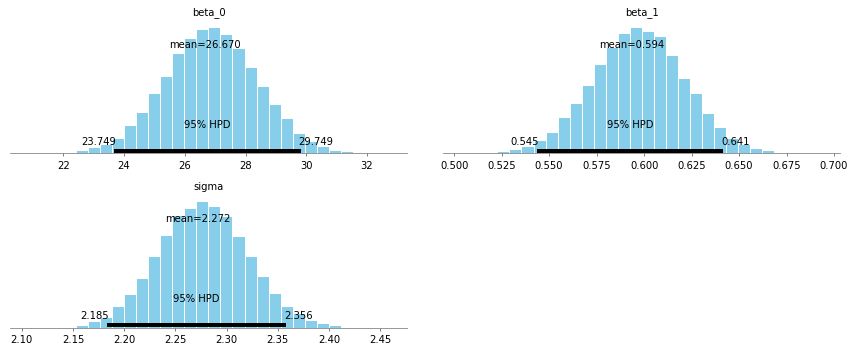

In [16]:
# Generate full posterior distributions.
pm.posteriorplot.plot_posterior(trace);

In [17]:
# Generate summaries of posterior distributions (and round to two decimal places).
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_0,26.670378,1.528625,0.013620,23.749296,29.748866,13638.006233,1.000114
beta_1,0.593681,0.024462,0.000218,0.544635,0.640584,13643.277082,1.000110
sigma,2.271663,0.043698,0.000322,2.185036,2.356161,17040.387797,0.999997


In [18]:
# You can get posterior draws from `trace` object.
trace.varnames

['beta_0', 'beta_1', 'sigma_interval__', 'sigma']

In [21]:
np.mean(trace['beta_1'])

0.5936806895631432

(array([   47.,   463.,  2356.,  6774., 11537., 11053.,  5741.,  1685.,
          315.,    29.]),
 array([0.50069555, 0.5196688 , 0.53864205, 0.5576153 , 0.57658854,
        0.59556179, 0.61453504, 0.63350829, 0.65248154, 0.67145479,
        0.69042804]),
 <a list of 10 Patch objects>)

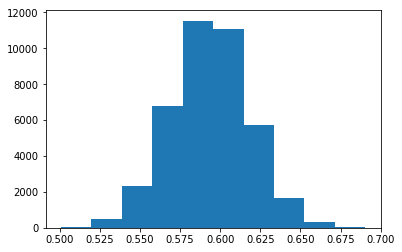

In [22]:
plt.hist(trace['beta_1'])

### Compare to `statsmodels`.

In [23]:
import statsmodels.api as sm

In [24]:
y = df['Dheight']
X = df['Mheight']
X = sm.add_constant(X)

In [25]:
lm = sm.OLS(y,X).fit()

In [26]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Dheight   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     435.5
Date:                Tue, 23 Apr 2019   Prob (F-statistic):           3.22e-84
Time:                        13:40:37   Log-Likelihood:                -3075.0
No. Observations:                1375   AIC:                             6154.
Df Residuals:                    1373   BIC:                             6164.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.9174      1.622     18.439      0.000      26.735      33.100
Mheight        0.5417      0.026     20.868      0.000       0.491       0.593
==============================================================================
Omnibus:                        1.412   Durbin-Watson:                   0.126
Prob(Omnibus):                  0.494   Jarque-Bera (JB):                1.353
Skew:                           0.002   Prob(JB):                        0.508
Kurtosis:                       3.154   Cond. No.                     1.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""